<a href="https://colab.research.google.com/github/zeinabkamkar98/graph-classification/blob/main/GraphClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Baseline Algorithm for Graph Classification

##### Requirements 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import networkx as nx
import numpy as np
import pandas as pd

from scipy import sparse

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score

%matplotlib inline


### Loading all datasets

In [ ]:
class GraphDataset:
    def __init__(self, folder_path=''):

        G = nx.Graph()
        data_adj = np.loadtxt(folder_path + '_A.txt', delimiter=',').astype(int)
        data_graph_indicator = np.loadtxt(folder_path + '_graph_indicator.txt', delimiter=',').astype(int)
        labels = np.loadtxt(folder_path + '_graph_labels.txt', delimiter=',').astype(int)

        data_tuple = list(map(tuple, data_adj))
        G.add_edges_from(data_tuple)
        G.remove_nodes_from(list(nx.isolates(G)))

        # split into graphs

        le = LabelEncoder()
        self.labels_ = le.fit_transform(labels)
        self.n_classes_ = len(le.classes_)
        self.n_graphs_ = len(self.labels_)

        graph_num = data_graph_indicator.max()
        node_list = np.arange(data_graph_indicator.shape[0]) + 1
        self.graphs_ = []

        for i in range(graph_num):

            nodes = node_list[data_graph_indicator == i + 1]
            G_sub = G.subgraph(nodes).copy()
            
            max_cc = max(nx.connected_components(G_sub), key=len)
            G_sub = G_sub.subgraph(max_cc).copy()
            G_sub.graph['label'] = self.labels_ [i]
            nx.convert_node_labels_to_integers(G_sub)
            self.graphs_.append(G_sub)     

        self.graphs_ = np.array(self.graphs_)

        print('Loaded')

In [ ]:
# graphs_name = ['COX2','AIDS','ENZYMES','DD','MUTAG','NCI1','PROTEINS_full','PTC_MR']
graphs_name = ['COX2']
data_pwd = 'drive/MyDrive/DATASETS/'

In [ ]:
datasets = {}
for gn in graphs_name:
    print(gn)
    datasets[gn] = GraphDataset(folder_path=data_pwd + gn + '/' + gn)

COX2
Loaded


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Spectral embedding, reshaping and training

Embedding of the nodes: creation of the spectral features

In [ ]:
def padded_spectral(graph, embedding_dimension=16, normalized=True):
    
    # Padding with zeros
    embedding = np.zeros(embedding_dimension)
    
    # Usage of networkx graph objects
    adj_matrix = nx.adj_matrix(graph)
    n_nodes, m_nodes = adj_matrix.shape
    k = min(embedding_dimension + 1, n_nodes - 1)

    if normalized:
        laplacian = nx.normalized_laplacian_matrix(graph)
    else:
        laplacian = nx.laplacian_matrix(graph)

    # Minus the eigen decomposition of minus the Laplacian is more stable than directly
    # computing the eigen decomposition of the Laplacian
    
    v0 = np.random.uniform(-1, 1, laplacian.shape[0])
    eigenvalues = sparse.linalg.eigsh(-laplacian, k=k, sigma=1.0, which='LM', tol=1e-6, v0=v0, return_eigenvectors=False)
    embedding[:len(eigenvalues)-1] = sorted(-eigenvalues)[1:]
    
    return embedding

In [ ]:
def dataset_embedding(dataset, embedding_dim, normalized=True):

    list_graphs = []
    for g in dataset.graphs_:
        x = padded_spectral(g, embedding_dim, normalized)
        y = g.graph['label']

        list_graphs.append((x, y))

    X = np.array([l[0] for l in list_graphs])
    labels = np.array([l[1] for l in list_graphs])
    
    return X, labels

In [ ]:
# Mean number of nodes per dataset

embedding_dims = {'AIDS':16 ,'ENZYMES': 33,'DD':	284,'MUTAG':18,'NCI1':30,'PROTEINS_full':39,'PTC_MR':14}

In [ ]:
embedded_datasets = {}

for name, dataset in datasets.items():
    k = embedding_dims[name]
    X, y = dataset_embedding(dataset, k)
    embedded_datasets[name] = {'X': X, 'y': y}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  import sys


Training for all datasets and embedding dimensions

In [ ]:
rf_parameters = {'n_estimators': 500, 'max_depth': 100}

for name, dataset in datasets.items():

    X, y = embedded_datasets[name]['X'], embedded_datasets[name]['y']

    rf = RandomForestClassifier(**rf_parameters, random_state=1, class_weight='balanced') 
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    cv_results = cross_val_score(rf, X, y, n_jobs=1, cv=skf, scoring='accuracy')
    
    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format(name, X.shape[1], np.mean(cv_results)))

Dataset: AIDS, Embedding dim: 16, Accuracy: 0.998500
Dataset: ENZYMES, Embedding dim: 33, Accuracy: 0.438333
Dataset: DD, Embedding dim: 284, Accuracy: 0.753057
Dataset: MUTAG, Embedding dim: 18, Accuracy: 0.877778
Dataset: NCI1, Embedding dim: 30, Accuracy: 0.750608
Dataset: PROTEINS_full, Embedding dim: 39, Accuracy: 0.724147
Dataset: PTC_MR, Embedding dim: 14, Accuracy: 0.592437


Study on hyper-parametrization

In [ ]:
import pandas as pd

hp_test_means, hp_test_std = {}, {}

rf_parameters_grid = {'n_estimators': [1, 10, 50, 100, 250, 750, 1000], 
                         'min_samples_leaf': [2, 3, 4, 5, 6], 
                         'max_depth': [1, 5, 10, 50, 250, 500, 750, 1000], 
                         'bootstrap': [False]}


rf_parameters_default = {'n_estimators': 500, 'min_samples_leaf': 1, 'max_depth': 100, 
                         'bootstrap': True, 'class_weight': 'balanced'}

# Non default parameters

for para_name in rf_parameters_grid:
    
    parameters_index = rf_parameters_grid[para_name] + [rf_parameters_default[para_name]]
    parameters_index.sort()
    
    hp_test_means[para_name] = pd.DataFrame(index=parameters_index, columns=list(datasets.keys()))
    hp_test_std[para_name] = pd.DataFrame(index=parameters_index, columns=list(datasets.keys()))
    
    rf_parameters = rf_parameters_default.copy()
    
    for para_val in rf_parameters_grid[para_name]:
        
        rf_parameters[para_name] = para_val
        
        for name, dataset in datasets.items():

            X, y = embedded_datasets[name]['X'], embedded_datasets[name]['y']

            rf = RandomForestClassifier(**rf_parameters, random_state=1)
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
            
            cv_results = cross_val_score(rf, X, y, n_jobs=1, cv=skf, scoring='accuracy')
            hp_test_means[para_name][name][para_val] = np.mean(cv_results)
            hp_test_std[para_name][name][para_val] = np.std(cv_results)
            
# Default parameters

rf_parameters = rf_parameters_default.copy()

for name, dataset in datasets.items():

    X, y = embedded_datasets[name]['X'], embedded_datasets[name]['y']

    rf = RandomForestClassifier(**rf_parameters, random_state=1) 
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    cv_results = cross_val_score(rf, X, y, n_jobs=1, cv=skf, scoring='accuracy')
    
    for para_name in rf_parameters_grid:
        hp_test_means[para_name][name][rf_parameters[para_name]] = np.mean(cv_results)
        hp_test_std[para_name][name][rf_parameters[para_name]] = np.std(cv_results)     

In [ ]:
hp_test_means['n_estimators']

,ENZYMES
1,0.288333
10,0.393333
50,0.436667
100,0.43
250,0.433333
500,0.438333
750,0.441667
1000,0.441667


In [ ]:
hp_test_means['min_samples_leaf']

,ENZYMES
1,0.438333
2,0.416667
3,0.418333
4,0.4
5,0.398333
6,0.378333


In [ ]:
hp_test_means['max_depth']

,ENZYMES
1,0.268333
5,0.353333
10,0.435
50,0.438333
100,0.438333
250,0.438333
500,0.438333
750,0.438333
1000,0.438333


In [ ]:
hp_test_means['bootstrap']

,ENZYMES
False,0.438333
True,0.438333


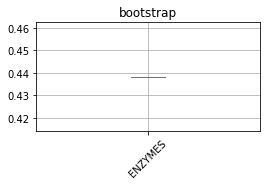

In [ ]:
hp_test_means['bootstrap'].plot(kind='box', figsize=(4, 2), grid=True, title='bootstrap', rot=45)

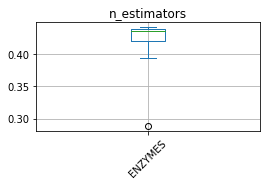

In [ ]:
hp_test_means['n_estimators'].plot(kind='box', figsize=(4, 2), grid=True, title='n_estimators', rot=45)

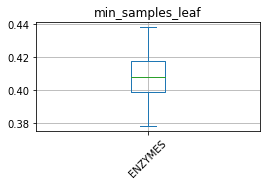

In [ ]:
hp_test_means['min_samples_leaf'].plot(kind='box', figsize=(4, 2), grid=True, title='min_samples_leaf', rot=45)

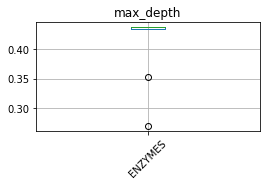

In [ ]:
hp_test_means['max_depth'].plot(kind='box', figsize=(4, 2), grid=True, title='max_depth', rot=45)